In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def Thomas_algo1(a, b, c, d):
    n = len(d) 
    _c = np.zeros(n)
    _d = np.zeros(n)
    x = np.zeros(n)
    _c[0] = c[0]/a[0]
    _d[0] = d[0]/a[0]
    for i in range(1, n):
        _c[i] = ( c[i] / (a[i]-b[i]*_c[i-1]) )
        _d[i] = ( (d[i] - b[i] * _d[i-1]) / (a[i] - b[i] * _c[i-1]) )
        
    x[n-1] = _d[n-1]
    for i in range(n-2, -1, -1):
        x[i] = _d[i] - _c[i] * x[i+1]
    
    return x

def Thomas_algo2(a, b, c, d):
    n = len(d) 
    _a = np.zeros(n)
    _d = np.zeros(n)
    x = np.zeros(n)
    _a[0] = a[0]
    _d[0] = d[0]
    for i in range(1, n):
        _a[i] = a[i] - b[i] * c[i-1]/_a[i-1]
        _d[i] =  d[i] - b[i] * _d[i-1] / _a[i-1]
    
    _a[n-1] = a[n-1] - b[n-1]*c[n-2]/_a[n-2]
    _d[n-1] = d[n-1] - b[n-1]*_d[n-2]/_a[n-2]
        
    x[n-1] = _d[n-1]/_a[n-1]
    for i in range(n-2, -1, -1):
        x[i] = _d[i]/_a[i] - c[i]/_a[i] * x[i+1]
    return x


## IFDM : 이해를 돕기 위해서 해본 것.

In [3]:
calls = ['call', 'Call', 'c', 'C']
puts = ['put', 'Put', 'p', 'P']



#### IFDM of vanilla put/call option ####
def IFDM(opt_type, x, r, vol, N, I, D, dx, dt):
    u = np.zeros((N+1, I+1)) # (time, price)
    # boundary condition : 0 time point
    if opt_type in calls:
        for i in range(I+1):
            u[0][i] = max(0 + i * dx - K, 0)
    elif opt_type in puts:
        for i in range(I+1):
            u[0][i] = max(K - dx * i - 0, 0)
    else:
        print('option type error!')
        return
    
    # boundary condition : Smax or Smin
    if opt_type in calls:
        u[1:N+1, 0] = 0
        u[1:N+1, I] = 0 + I * dx * np.exp(-D * np.arange(1, N+1) * dt) - K * np.exp(-r * np.arange(1, N+1) * dt)
    else:
        u[1:N+1, 0] = K * np.exp(-r * np.arange(1, N+1) * dt)
        u[1:N+1, I] = 0
    
    
    # a, b, c
    tmp = np.arange(1, I)
    a = 1 + dt * (r + (vol**2) * (tmp*tmp))
    b = (dt/2) * ((r - D) * tmp - (vol**2) * (tmp*tmp))
    c = (dt/2) * (-(r - D) * tmp - (vol**2) * (tmp*tmp))
    
    # d & updated u
    for i in range(1, N+1):
        d = u[i-1][1: I]
        d[0] = d[0] - b[0]* u[i][0]
        d[I-2] = d[I-2] - c[I-2] * u[i][I]
        u[i][1:I] = Thomas_algo1(a, b, c, d)
    
    return u

In [4]:
vol = 0.2 # volatility in document
x = 10 # 2020년 3월 2일의 KOSPI200 index
r = 0.05 # 임의로 잡았음.
N = 1000 # time 쪼갠 갯수!
I = 500 # 가격 쪼갠 갯수!
K = 10 # strike price
M = 0.5 # maturity
D = 0 # dividend
dx = 20/I
dt = M/N

In [5]:
res_plain_IFDM = IFDM('put', x, r, vol, N, I, D, dx, dt)

In [6]:
price_plain_IFDM = np.zeros((I+1, 2))
price_plain_IFDM[:, 0] = 0 + np.arange(0, I+1) * dx
price_plain_IFDM[:, 1] = res_plain_IFDM[N]

In [7]:
price_plain_IFDM[len(price_plain_IFDM)//2]

array([10.        ,  0.44184716])

교수님 PPT속 예제가 잘 출력된다. 이제 CNFDM을 보도록 하자.

## CNFDM : 기본 함수 코드

In [8]:
#### IFDM of vanilla put/call option ####
def CNFDM(opt_type, x, r, vol, N, I, D, dx, dt):
    u = np.zeros((N+1, I+1)) # (time, price)
    # boundary condition : 0 time point
    if opt_type in calls:
        for i in range(I+1):
            u[0][i] = max(0 + i * dx - K, 0)
    elif opt_type in puts:
        for i in range(I+1):
            u[0][i] = max(K - dx * i - 0, 0)
    else:
        print('option type error!')
        return
    
    # boundary condition : Smax or Smin
    if opt_type in calls:
        u[1:N+1, 0] = 0
        u[1:N+1, I] = 0 + I * dx * np.exp(-D * np.arange(1, N+1) * dt) - K * np.exp(-r * np.arange(1, N+1) * dt)
    else:
        u[1:N+1, 0] = K * np.exp(-r * np.arange(1, N+1) * dt)
        u[1:N+1, I] = 0
    
    
    # a, b, c
    tmp = np.arange(1, I)
    a = (dt/2) * (r + (vol**2) * (tmp*tmp))
    b = (dt/4) * ((r - D) * tmp - (vol**2) * (tmp*tmp))
    c = (dt/4) * (-(r - D) * tmp - (vol**2) * (tmp*tmp))
    
    # d & updated u
    for i in range(1, N+1):
        d = -b*u[i-1][0: I-1] + (1 - a) * u[i-1, 1:I] - c * u[i-1, 2:I+1]
        d[0] = d[0] - b[0]* u[i][0]
        d[I-2] = d[I-2] - c[I-2] * u[i][I]
        u[i][1:I] = Thomas_algo1(1+a, b, c, d)
    
    return u

In [9]:
vol = 0.2 # volatility in document
x = 10 # 2020년 3월 2일의 KOSPI200 index
r = 0.05 # 임의로 잡았음.
N = 1000 # time 쪼갠 갯수!
I = 500 # 가격 쪼갠 갯수!
K = 10 # strike price
M = 0.5 # maturity
D = 0 # dividend
dx = 20/I
dt = M/N

In [10]:
res_plain_CNFDM = CNFDM('put', x, r, vol, N, I, D, dx, dt)

In [11]:
price_plain_CNFDM = np.zeros((I+1, 2))
price_plain_CNFDM[:, 0] = 0 + np.arange(0, I+1) * dx
price_plain_CNFDM[:, 1] = res_plain_CNFDM[N]

In [12]:
price_plain_CNFDM[len(price_plain_CNFDM)//2]

array([10.        ,  0.44191582])

교수님이 내주신 예제와 같은 값이 나온다.

## 강의 예제 기반 IFDM

In [13]:
r = 0.0177
D = 0
s0 = 200
cr = [0.0215, 0.043, 0.0645, 0.086, 0.1075, 0.129]
K = [0.95, 0.95, 0.95, 0.90, 0.90, 0.90]
dates = [0, 0.5, 1, 1.5, 2, 2.5]
B = 0.65
vol = 0.2

In [14]:
dx = s0 * 0.01
I = 400
Smax = dx * I
Smin = 0
pp = 50 # number of time points
N = 6 * pp
T = 3 # maturity

In [15]:
def ELS_OneStar_IFDM(Smin, Smax, vol, r, D, S0, cr, K, B, T, I, N, dates):
    dt = T/N
    S = np.linspace(Smin, Smax, I+1)
    S0_point = np.where(S == S0)[0][0]
    x = S/S0
    # Coefficients of x for IFDM and boundary condition adjustment
    tmp = np.arange(1, I)
    a = 1 + dt*(r + (vol**2) * (tmp*tmp))
    b = (dt/2) * ((r-D) * tmp - (vol**2) * (tmp*tmp))
    c = (dt/2) * (-(r-D) * tmp - (vol**2) * (tmp*tmp))
    a_prime = a.copy()
    b_prime = b.copy()
    c_prime = c.copy()
    a_prime[0] = a[0] + 2*b[0]
    c_prime[0] = c[0] - b[0]
    a_prime[I-2] = a[I-2] + 2*c[I-2]
    b_prime[I-2] = b[I-2] - c[I-2]
    # Initial conditions, u(0, j) and w(0, j) are determined
    u = np.zeros((N+1, I+1))
    w = np.zeros((N+1, I+1))
    for j in range(I):
        # u
        if(x[j] > B):
            u[0][j] = 1 + cr[5]
        else:
            u[0][j] = x[j]
        # w
        if x[j] >= K[-1]:
            w[0][j] = (1 + cr[5])
        else:
            w[0][j] = x[j]
    
    # Linear boundary condition
#     u[1:N+1, 0] = 2 * u[1:N+1, 1] - u[1:N+1, 2]
#     u[1:N+1, I] = 2 * u[1:N+1, I-1] - u[1:N+1, I-2]
#     w[1:N+1, 0] = 2 * w[1:N+1, 1] - w[1:N+1, 2]
#     w[1:N+1, I] = 2 * w[1:N+1, I-1] - w[1:N+1, I-2]
    u[0, 0] = 2 * u[0, 1] - u[0, 2]
    u[0, I] = 2 * u[0, I-1] - u[0, I-2]
    w[0, 0] = 2 * w[0, 1] - w[0, 2]
    w[0, I] = 2 * w[0, I-1] - w[0, I-2]
#     print(a.shape)
#     print(b.shape)
#     print(c.shape)
    Btag = int(round(S0_point* B)) # Btag : barrier 가격의 index
    for i in range(1, N+1):
        d = u[i-1, 1:I]
        u[i, 1:I] = Thomas_algo1(a_prime, b_prime, c_prime, d) # CN에서는 a -> 1+a, 
        d2 = w[i-1, 1:I]
        w[i, 1:I] = Thomas_algo1(a_prime, b_prime, c_prime, d2) # b, c -> I-2개(slicing) 필요.
        
#         print(i)
#         print('u :', u[i])
#         print('w :', w[i])

        # fix under barrier
        u[i, 1:Btag+1] = w[i, 1:Btag+1]
        
        # fix over strike price at the early redemtion date.
        if i*dt in dates:
#             print(i)
#             print('period:', round(i*dt, 1))
            dummy = int(round(S0_point * K[len(K) -1 - round(i*dt*2)])) # dummy : strike price index
#             print('strike price:', S0_point * K[len(K) -1 - round(i*dt*2)])
            u[i, dummy : I+1] = 1 + cr[round(len(cr) - round(i*dt, 1)*2)-1]
            w[i, dummy : I+1] = 1 + cr[round(len(cr) - round(i*dt, 1)*2)-1]
#             print('third:', round(len(cr) - round(i*dt, 1)*2)-1)
#             print('fourth:', 1 + cr[round(len(cr) - round(i*dt, 1)*2)-1])
        u[i][0] = 2 * u[i][1] - u[i][2]
        u[i][I] = 2 * u[i][I-1] - u[i][I-2]
        w[i][0] = 2 * w[i][1] - w[i][2]
        w[i][I] = 2 * w[i][I-1] - w[i][I-2]
        
        
    return u, w

In [16]:
U_ELS_IFDM, W_ELS_IFDM = ELS_OneStar_IFDM(Smin, Smax, vol, r, D, s0, cr, K, B, T, I, N, dates)

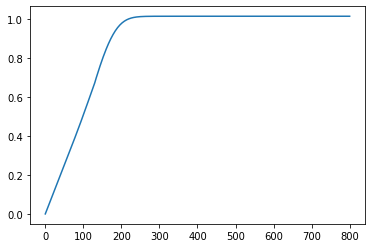

In [17]:
plt.plot(dx*np.arange(len(U_ELS_IFDM[N])), U_ELS_IFDM[N])
plt.show()

In [18]:
price_ELS_IFDM_E= np.zeros((I+1, 2))
price_ELS_IFDM_E[:, 0] = 0 + np.arange(0, I+1) * dx
price_ELS_IFDM_E[:, 1] = U_ELS_IFDM[N]
price_ELS_IFDM_E[len(price_ELS_IFDM_E)//4] # U

array([200.        ,   0.97528244])

In [19]:
price_ELS_IFDM_W= np.zeros((I+1, 2))
price_ELS_IFDM_W[:, 0] = 0 + np.arange(0, I+1) * dx
price_ELS_IFDM_W[:, 1] = W_ELS_IFDM[N]
price_ELS_IFDM_W[len(price_ELS_IFDM_W)//4] # W

array([200.       ,   0.9671785])

IFDM을 이용한 ELS pricing도 무난하게 된 것 같다! 이제 CNFDM으로 ELS pricing을 해보자!

In [20]:
def ELS_OneStar_CNFDM(Smin, Smax, vol, r, D, S0, cr, K, B, T, I, N, dates):
    dt = T/N
    S = np.linspace(Smin, Smax, I+1)
    S0_point = np.where(S == S0)[0][0]
    x = S/S0
    # Coefficients of x for IFDM and boundary condition adjustment
    tmp = np.arange(1, I)
    a = dt/2*(r + (vol**2) * (tmp*tmp))
    b = (dt/4) * ((r-D) * tmp - (vol**2) * (tmp*tmp))
    c = (dt/4) * (-(r-D) * tmp - (vol**2) * (tmp*tmp))
    a_prime = a.copy()
    b_prime = b.copy()
    c_prime = c.copy()
    a_prime[0] = a[0] + 2*b[0]
    c_prime[0] = c[0] - b[0]
    a_prime[I-2] = a[I-2] + 2*c[I-2]
    b_prime[I-2] = b[I-2] - c[I-2]

    # Initial conditions, u(0, j) and w(0, j) are determined
    u = np.zeros((N+1, I+1))
    w = np.zeros((N+1, I+1))
    for j in range(I):
        # u
        if(x[j] > B):
            u[0][j] = 1 + cr[5]
        else:
            u[0][j] = x[j]
        # w
        if x[j] >= K[-1]:
            w[0][j] = (1 + cr[5])
        else:
            w[0][j] = x[j]
    
    # Linear boundary condition
#     u[1:N+1, 0] = 2 * u[1:N+1, 1] - u[1:N+1, 2]
#     u[1:N+1, I] = 2 * u[1:N+1, I-1] - u[1:N+1, I-2]
#     w[1:N+1, 0] = 2 * w[1:N+1, 1] - w[1:N+1, 2]
#     w[1:N+1, I] = 2 * w[1:N+1, I-1] - w[1:N+1, I-2]
    u[0, 0] = 2 * u[0, 1] - u[0, 2]
    u[0, I] = 2 * u[0, I-1] - u[0, I-2]
    w[0, 0] = 2 * w[0, 1] - w[0, 2]
    w[0, I] = 2 * w[0, I-1] - w[0, I-2]
#     print(a.shape)
#     print(b.shape)
#     print(c.shape)
    Btag = int(round(S0_point* B)) # Btag : barrier 가격의 index
    for i in range(1, N+1):
        d = -b*u[i-1][0: I-1] + (1 - a) * u[i-1, 1:I] - c * u[i-1, 2:I+1]
        d[0] = d[0] - b[0]* u[i][0]
        d[I-2] = d[I-2] - c[I-2] * u[i][I]
        d2 = -b*w[i-1][0: I-1] + (1 - a) * w[i-1, 1:I] - c * w[i-1, 2:I+1]
        d2[0] = d2[0] - b[0]* w[i][0]
        d2[I-2] = d2[I-2] - c[I-2] * w[i][I]
        u[i, 1:I] = Thomas_algo1(1+a_prime, b_prime, c_prime, d) # CN에서는 a -> 1+a, 
        w[i, 1:I] = Thomas_algo1(1+a_prime, b_prime, c_prime, d2) # b, c -> I-2개(slicing) 필요.
        
#         print(i)
#         print('u :', u[i])
#         print('w :', w[i])

        # fix under barrier
        u[i, 1:Btag+1] = w[i, 1:Btag+1]
        
        # fix over strike price at the early redemtion date.
        if i*dt in dates:
#             print(i)
#             print('period:', round(i*dt, 1))
            dummy = int(round(S0_point * K[len(K) -1 - round(i*dt*2)])) # dummy : strike price index
#             print('strike price:', S0_point * K[len(K) -1 - round(i*dt*2)])
            u[i, dummy : I+1] = 1 + cr[round(len(cr) - round(i*dt, 1)*2)-1]
            w[i, dummy : I+1] = 1 + cr[round(len(cr) - round(i*dt, 1)*2)-1]
#             print('third:', round(len(cr) - round(i*dt, 1)*2)-1)
#             print('fourth:', 1 + cr[round(len(cr) - round(i*dt, 1)*2)-1])
        u[i][0] = 2 * u[i][1] - u[i][2]
        u[i][I] = 2 * u[i][I-1] - u[i][I-2]
        w[i][0] = 2 * w[i][1] - w[i][2]
        w[i][I] = 2 * w[i][I-1] - w[i][I-2]
        
        
    return u, w

In [21]:
U_ELS_CNFDM, W_ELS_CNFDM = ELS_OneStar_CNFDM(Smin, Smax, vol, r, D, s0, cr, K, B, T, I, N, dates)

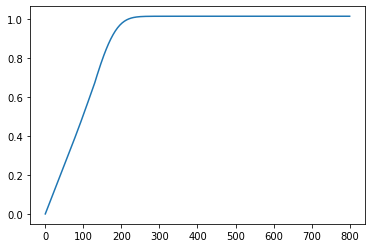

In [22]:
plt.plot(dx*np.arange(len(U_ELS_CNFDM[N])), U_ELS_CNFDM[N])
plt.show()

In [23]:
price_ELS_CNFDM_E = np.zeros((I+1, 2))
price_ELS_CNFDM_E[:, 0] = 0 + np.arange(0, I+1) * dx
price_ELS_CNFDM_E[:, 1] = U_ELS_CNFDM[N]
price_ELS_CNFDM_E[len(price_ELS_CNFDM_E)//4] # U

array([200.        ,   0.97475793])

In [24]:
price_ELS_CNFDM_W= np.zeros((I+1, 2))
price_ELS_CNFDM_W[:, 0] = 0 + np.arange(0, I+1) * dx
price_ELS_CNFDM_W[:, 1] = W_ELS_CNFDM[N]
price_ELS_CNFDM_W[len(price_ELS_CNFDM_W)//4] # W

array([200.        ,   0.96705272])

교수님 예제의 CNFDM이 IFDM과 꽤 비슷하게 나온다. 이제, 내가 찾은 ELS를 대상으로 해봐야겠다.

# NH투자증권 ELS 19279 - price : 9724.91원

In [25]:
r = 0.008 # 임의로 잡은 이자율.
D = 0
s0 = 271.56 # KOSPI200 index S0 : 270
cr = np.arange(1, 7) * 0.0225
K = [0.95, 0.95, 0.90, 0.90, 0.85, 0.80] # strike prices
dates = [0, 0.5, 1, 1.5, 2, 2.5] # 반년에 1번씩 early redemtion date
B = 0.65 # Barrier
vol = 0.1813 # NH투자증권 제공.
dx = s0 * 0.01
I = 400
Smax = dx * I
Smin = 0
pp = 50 # number of time points
N = 6 * pp
T = 3 # maturity

In [26]:
U_HW_IFDM, W_HW_IFDM = ELS_OneStar_IFDM(Smin, Smax, vol, r, D, s0, cr, K, B, T, I, N, dates)

In [27]:
price_HW_IFDM_E = np.zeros((I+1, 2))
price_HW_IFDM_E[:, 0] = 0 + np.arange(0, I+1) * dx
price_HW_IFDM_E[:, 1] = U_HW_IFDM[N]
price_HW_IFDM_E[len(price_HW_IFDM_E)//4] # U

array([271.56      ,   0.99358762])

In [28]:
price_HW_IFDM_W= np.zeros((I+1, 2))
price_HW_IFDM_W[:, 0] = 0 + np.arange(0, I+1) * dx
price_HW_IFDM_W[:, 1] = W_HW_IFDM[N]
price_HW_IFDM_W[len(price_HW_IFDM_W)//4] # U

array([271.56      ,   0.98767209])

In [29]:
U_HW_CNFDM, W_HW_CNFDM = ELS_OneStar_CNFDM(Smin, Smax, vol, r, D, s0, cr, K, B, T, I, N, dates)

In [30]:
price_HW_CNFDM_E= np.zeros((I+1, 2))
price_HW_CNFDM_E[:, 0] = 0 + np.arange(0, I+1) * dx
price_HW_CNFDM_E[:, 1] = U_HW_CNFDM[N]
price_HW_CNFDM_E[len(price_HW_CNFDM_E)//4] # U

array([271.56      ,   0.99317965])

In [31]:
price_HW_CNFDM_W= np.zeros((I+1, 2))
price_HW_CNFDM_W[:, 0] = 0 + np.arange(0, I+1) * dx
price_HW_CNFDM_W[:, 1] = W_HW_CNFDM[N]
price_HW_CNFDM_W[len(price_HW_CNFDM_W)//4] # U

array([271.56      ,   0.98757056])

내가 가져온 ELS의 프라이싱은 위와 같이 되었다. 시뮬레이션을 해봐야겠다.

In [32]:
def ELS_OneStar_Simulation(s0, mu, vol, r, D, cr, K, B, N, dates, T):
    S = np.zeros(N+1)
    x = np.zeros(N+1)
    dt = T/N
    x[0] = 1
    S[0] = s0
    cnt = 0.0
    total_iter = 10000
    sprice = 0
    for i in range(total_iter):
        KI = 0 # Knock-In
        # 하나의 시나리오 만들어내기.
        for j in range(N):
            e = np.random.randn(1)[0]
            S[j+1] = S[j] * (1+(mu-D)*dt + vol * np.sqrt(dt) * e) # Black-scholes Model
            x[j+1] = S[j+1]/s0
        
        # 시나리오의 상황을 체크한다.
        # 1. Barrier를 Knock-In 한적 있는가?
        if min(x) <= B:
            KI = 1
            cnt = cnt+1
        
        # 2. 첫번째 조기상환 기간에 조기상환 되었는가?
        if x[N//6] >= K[0]:
            price = (1+cr[0]) * np.exp(-r*dates[0])
        # 3. 두번째 조기상환 기간에 조기상환 되었는가?
        elif x[N//6*2] >= K[1]:
            price = (1+cr[1]) * np.exp(-r*dates[1])
        # 4. 세번째 조기상환 기간에 조기상환 되었는가?
        elif x[N//6*3] >= K[2]:
            price = (1+cr[2]) * np.exp(-r*dates[2])
        # 5. 네번째 조기상환 기간에 조기상환 되었는가?
        elif x[N//6*4] >= K[3]:
            price = (1+cr[3]) * np.exp(-r*dates[3])
        # 6. 다섯번째 조기상환 기간에 조기상환 되었는가?
        elif x[N//6*5] >= K[4]:
            price = (1+cr[4]) * np.exp(-r*dates[4])
        # 7. 만기 상환관련 이슈. 만기에 가격이 행사가격보다 높은가?
        elif x[N] >= K[5]:
            price = (1+cr[5]) * np.exp(-r*dates[5])
        # 8. 두 번째 만기 관련 이슈. 배리어를 친적이 있는가? 그렇다면, 행사가격보다 낮기도 하기 때문에.. 낮은가격!
        elif KI == 1:
            price = x[N] * np.exp(-r*dates[5])
        else: # 배리어를 친 적은 없고, 만기 가격이 (배리어 ~ 행사가격) 사이인 경우.
            price = (1+cr[5]) * np.exp(-r*dates[5])
        sprice = sprice + price
    sprice = sprice / total_iter
    prob = cnt / total_iter
    print('Simulation price and probability of KI: %.4f, %.4f \n\n' %(sprice, prob))
    

In [33]:
dates = np.arange(1, 7) * 0.5
price_HW_sim = ELS_OneStar_Simulation(s0, r, vol, r, D, cr, K, B, N, dates, T)

Simulation price and probability of KI: 0.9928, 0.1778 




In [34]:
u = 10000 * U_HW_CNFDM[N] # price of derivatives
delta = []
gamma = []
for i in range(I):
    delta.append( (u[i+1] - u[i]) / dx )
for i in range(1, I):
    gamma.append( ( u[i+1]-2*u[i]+u[i-1] ) / dx )
u_1, _ = ELS_OneStar_CNFDM(Smin, Smax, vol, r, D, s0, cr, K, B, T, I, N, dates)
u_1 = 10000 * u_1[N][I//4]
u_2, _ = ELS_OneStar_CNFDM(Smin, Smax, vol+0.01, r, D, s0, cr, K, B, T, I, N, dates)
u_2 = 10000 * u_2[N][I//4]
vega = (u_2-u_1)/0.01
print('delta :', delta[I//4])
print('gamma :', gamma[I//4])
print('vega :', vega)

delta : 9.87977616296134
gamma : -0.8666897189293788
vega : 0.0


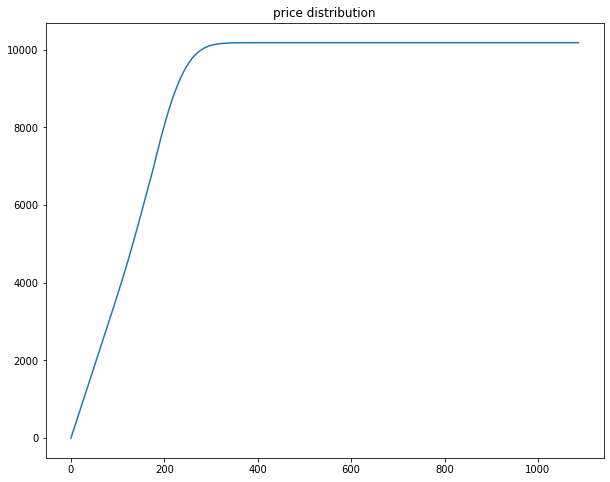

In [35]:
# price plot
plt.figure(figsize = (10, 8))
plt.title("price distribution")
plt.plot(np.arange(len(u)) * dx, u)
#plt.xlim([0, 100])
plt.show()

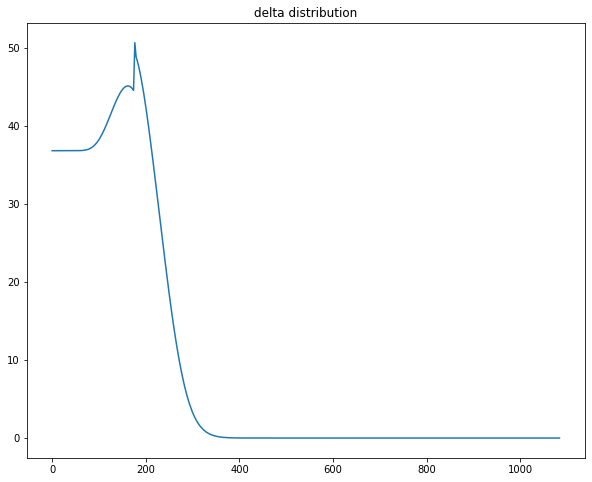

In [36]:
# delta plot
plt.figure(figsize = (10, 8))
plt.title("delta distribution")
plt.plot(np.arange(len(delta)) * dx, delta)
#plt.xlim([0, 100])
plt.show()

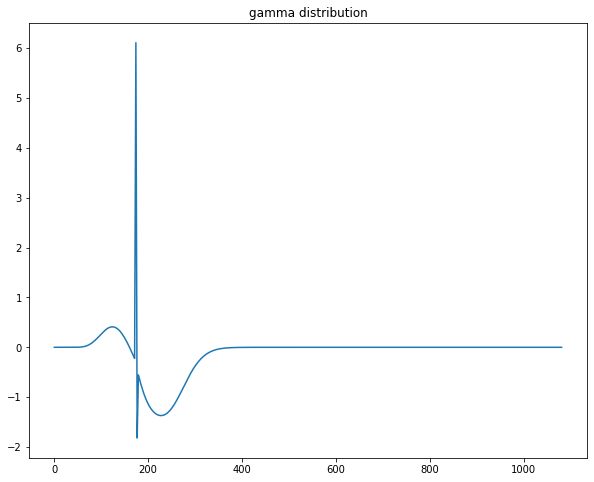

In [37]:
# gamma plot
plt.figure(figsize = (10, 8))
plt.plot(np.arange(len(gamma)) * dx, gamma)
plt.title("gamma distribution")
#plt.xlim([0, 100])
plt.show()

In [38]:
delta[5]

36.82427456179571